In [1]:
!pip install torchmetrics pytorch-lightning==2.2.1 timm seaborn tabulate

from google.colab import drive
import os
import shutil
from PIL import Image
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torch.nn as nn
import torchvision.models as models
from torchmetrics.classification import Accuracy, Recall, F1Score
from pytorch_lightning.callbacks import ModelCheckpoint
from tabulate import tabulate # Used for printing the final results table

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.2 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
SOURCE_DIR = "/content/drive/MyDrive/data"
LOCAL_DIR = "/content/local_data"
DATA_DIR = LOCAL_DIR

print("🚀 Copying data from Drive to Colab local storage...")

# If folder does not exist locally → copy from Drive
if not os.path.exists(LOCAL_DIR):
    shutil.copytree(SOURCE_DIR, LOCAL_DIR)
    print("✅ Copy completed!")
else:
    print("📂 Local data already exists — skipping copy.")

print("📌 Training will use:", DATA_DIR)

🚀 Copying data from Drive to Colab local storage...
✅ Copy completed!
📌 Training will use: /content/local_data


In [4]:
import os
print(os.listdir("/content/drive/MyDrive/data"))

['train', 'valid', 'test']


In [5]:
import os
import shutil
from google.colab import drive

# 1. Remount Drive (just to be safe)
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted.")

# 2. Define the NEW paths based on your update
# ----------------------------------------------
# ⚠️ THE CHANGE IS HERE ⚠️
SOURCE_DIR = "/content/drive/MyDrive/data"
# ----------------------------------------------
LOCAL_DIR = "/content/local_data"
DATA_DIR = LOCAL_DIR


print("🚀 Preparing for data copy...")

# --- Cleanup Incomplete Local Data ---
if os.path.exists(LOCAL_DIR):
    shutil.rmtree(LOCAL_DIR)
    print(f"🗑️ Deleted existing incomplete local data at: {LOCAL_DIR}")

# --- Copy Fresh Data from Drive ---
if not os.path.exists(LOCAL_DIR):
    try:
        shutil.copytree(SOURCE_DIR, LOCAL_DIR)
        print("✅ Copy completed successfully!")
    except FileNotFoundError:
        print(f"🚨 ERROR: Source directory not found at {SOURCE_DIR}")
        print("Please verify the path in Google Drive.")

else:
    print("📂 Local data already exists — skipping copy.")

DATA_DIR = LOCAL_DIR
print("\n📌 Training will now use:", DATA_DIR)

# --- Verification ---
if os.path.isdir(LOCAL_DIR):
    # This should now show ['train', 'valid', 'test'] (or similar)
    print(f"Contents of {LOCAL_DIR} now: {os.listdir(LOCAL_DIR)}")
else:
    print("🚨 LOCAL_DIR was not created! Check the FileNotFoundError above.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Preparing for data copy...
🗑️ Deleted existing incomplete local data at: /content/local_data
✅ Copy completed successfully!

📌 Training will now use: /content/local_data
Contents of /content/local_data now: ['valid', 'train', 'test']


In [6]:
def delete_corrupted_images(directory):
    """Deletes images that cannot be opened/verified by PIL."""
    deleted = 0
    for root, _, files in os.walk(directory):
        for f in files:
            path = os.path.join(root, f)
            try:
                # Open image and verify integrity
                img = Image.open(path)
                img.verify()
                img.close()
            except Exception:
                print("🗑️ Deleting corrupted:", path)
                os.remove(path)
                deleted += 1
    print(f"✔️ Deleted {deleted} corrupted images.")

# Run cleaning
delete_corrupted_images(DATA_DIR)

# Define transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
try:
    train_ds = ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
    val_ds   = ImageFolder(os.path.join(DATA_DIR, "valid"), transform=test_tfms)
    test_ds  = ImageFolder(os.path.join(DATA_DIR, "test"),  transform=test_tfms)
except RuntimeError as e:
    print(f"\n⚠️ Error loading ImageFolder: {e}")
    print("Please ensure your data structure is: /content/local_data/train/{class_name}/images...")
    raise

print("\n--- Dataset Info ---")
print("Train Samples:", len(train_ds))
print("Valid Samples:", len(val_ds))
print("Test Samples:", len(test_ds))

# Get class info
num_classes = len(train_ds.classes)
class_names = train_ds.classes
print("Number of classes:", num_classes)
print("Class Names:", class_names)
print("--------------------")

# Create dataloaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print("✅ Dataloaders ready!")

🗑️ Deleting corrupted: /content/local_data/train/ACCEPT/cast_ok_0_8016_jpeg.rf.d3cd5bc2eb139f71cb3351893fa0eece.jpg
🗑️ Deleting corrupted: /content/local_data/train/SURFACE IMPERFECTION/cast_def_0_4835_jpeg.rf.ccef46934213e8ac012c57a0e60be0c4.jpg
✔️ Deleted 2 corrupted images.

--- Dataset Info ---
Train Samples: 16915
Valid Samples: 1450
Test Samples: 788
Number of classes: 3
Class Names: ['ACCEPT', 'CASTING FAULT', 'SURFACE IMPERFECTION']
--------------------
✅ Dataloaders ready!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
class MobileNetV2Lit(pl.LightningModule):
    def __init__(self, num_classes, class_names):
        super().__init__()
        self.num_classes = num_classes
        self.class_names = class_names

        # Load MobileNetV2 with pre-trained weights and modify classifier head
        self.model = models.mobilenet_v2(weights="IMAGENET1K_V1")
        self.model.classifier[1] = nn.Linear(1280, num_classes)

        self.criterion = nn.CrossEntropyLoss()

        # Metrics for validation (macro avg)
        self.acc = Accuracy(task="multiclass", num_classes=num_classes)

        # Metrics for testing (Per-class Recall using average='none')
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes, average="macro")
        self.test_recall = Recall(task="multiclass", num_classes=num_classes, average="none")

        self.train_losses = []
        self.val_losses = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)

        acc = self.acc(preds, y)
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)

        self.test_acc.update(preds, y)
        self.test_recall.update(preds, y)

        self.log("test_loss", loss)

    def on_test_epoch_end(self):
        # Compute final metrics from all test steps
        final_acc = self.test_acc.compute()
        final_recall = self.test_recall.compute()

        # Print the requested results table
        print("\n--- Final Test Results ---")

        results_table = []
        results_table.append(["Metric", "Value"])
        results_table.append(["Overall Accuracy (Macro Avg)", f"{final_acc.item():.4f}"])

        # Map class recalls to class names for the specific required metrics
        for i, class_name in enumerate(self.class_names):
            recall_value = final_recall[i].item()
            # Clean up class names for table (e.g., 'casting_fault' -> 'Casting Fault Recall')
            metric_name = f"{class_name.replace('_', ' ').title()} Recall"
            results_table.append([metric_name, f"{recall_value:.4f}"])

        # Print using tabulate for a clean markdown table
        print(tabulate(results_table, headers="firstrow", tablefmt="github"))

        # Reset metrics for next test
        self.test_acc.reset()
        self.test_recall.reset()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [8]:
# 1. Initialize Model
model = MobileNetV2Lit(num_classes, class_names)

# 2. Setup Checkpointing and Trainer
checkpoint = ModelCheckpoint(
    dirpath="weights",
    filename="mobilenetv2_best",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint]
)

print("\nStarting Model Training (10 Epochs)...")

# 3. Train the Model
trainer.fit(model, train_dl, val_dl)

print("\n✅ Training Complete!")
print(f"Best model saved at: {checkpoint.best_model_path}")

# 4. Test the Model using the best checkpoint
print("\nTesting the best checkpoint model on the Test Set...")

# Load the best weights saved during training
trainer.test(model, test_dl, ckpt_path=checkpoint.best_model_path)

print("\n--- End of Execution ---")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 93.8MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Starting Model Training (10 Epochs)...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | model       | MobileNetV2        | 2.2 M 
1 | criterion   | CrossEntropyLoss   | 0     
2 | acc         | MulticlassAccuracy | 0     
3 | test_acc    | MulticlassAccuracy | 0     
4 | test_recall | MulticlassRecall   | 0     
---------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.911     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 529: 'val_acc' reached 0.87103 (best 0.87103), saving model to '/content/weights/mobilenetv2_best.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1058: 'val_acc' reached 0.87379 (best 0.87379), saving model to '/content/weights/mobilenetv2_best.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1587: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2116: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2645: 'val_acc' reached 0.87793 (best 0.87793), saving model to '/content/weights/mobilenetv2_best.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3174: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3703: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 4232: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 4761: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 5290: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/weights/mobilenetv2_best.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/weights/mobilenetv2_best.ckpt



✅ Training Complete!
Best model saved at: /content/weights/mobilenetv2_best.ckpt

Testing the best checkpoint model on the Test Set...


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Test Results ---
| Metric                       |   Value |
|------------------------------|---------|
| Overall Accuracy (Macro Avg) |  0.5892 |
| Accept Recall                |  0.9843 |
| Casting Fault Recall         |  0      |
| Surface Imperfection Recall  |  0.7833 |


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5154299736022949     │
└───────────────────────────┴───────────────────────────┘


--- End of Execution ---


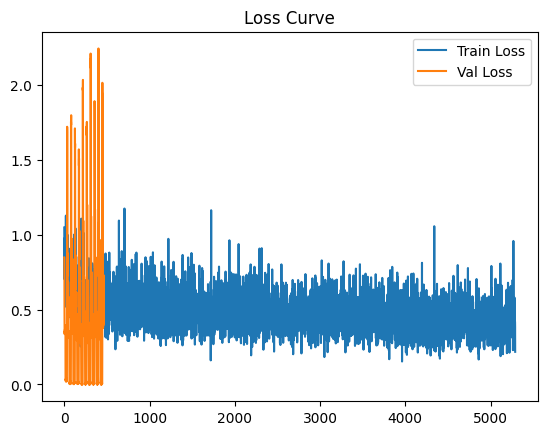

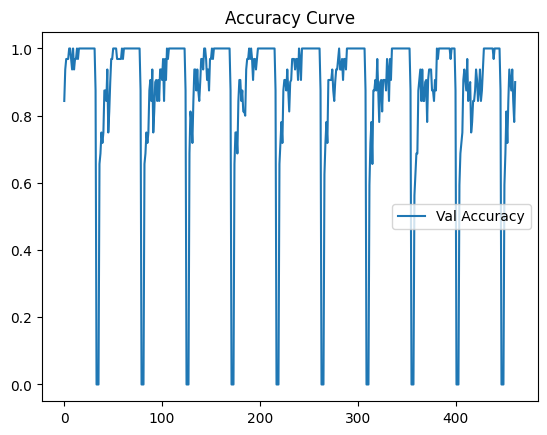

In [9]:
import matplotlib.pyplot as plt

plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(model.val_accs, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [12]:
# Assuming 'checkpoint' is your ModelCheckpoint instance and 'model_eca' is your trained Lightning module
import torch
import os

BEST_MODEL_PATH = checkpoint.best_model_path # Path where PyTorch Lightning saved the best weights

# 1. Load the best model weights
loaded_model = MobileNetV2Lit.load_from_checkpoint(
    BEST_MODEL_PATH,
    num_classes=num_classes,
    class_names=class_names
)

# 2. Define the output file name
OUTPUT_MODEL_FILE = "mobilenetv2.pth"

# 3. Save only the model's state dictionary (weights)
torch.save(loaded_model.state_dict(), OUTPUT_MODEL_FILE)

print(f"✅ Saved model weights to: {OUTPUT_MODEL_FILE}")

✅ Saved model weights to: mobilenetv2.pth


In [14]:
import json
import numpy as np

# --- Configuration ---
# Use the original model instance
trained_model = model
HISTORY_FILE = "cnn_history.json"

history_data = {
    # Store raw per-batch data
    "train_losses_batch": trained_model.train_losses,
    "val_losses_batch": trained_model.val_losses,
    "val_accs_batch": trained_model.val_accs,
}

# Convert all numpy floats (if any) to standard Python floats for JSON serialization
# This is crucial for JSON to work correctly.
history_data_serializable = {k: [float(x) for x in v] for k, v in history_data.items()}

with open(HISTORY_FILE, 'w') as f:
    json.dump(history_data_serializable, f, indent=4)

print(f"✅ 2. Saved training history to: {HISTORY_FILE}")

✅ 2. Saved training history to: cnn_history.json


In [17]:
import torch
from torchmetrics.classification import Accuracy, Recall

RESULTS_FILE = "cnn_test_results.json"

# 1. Define the metrics manually for calculation and move them to the device
# Get the model's device
device = next(loaded_model.parameters()).device
print(f"Model and metrics will use device: {device}")

test_acc_metric = Accuracy(task="multiclass", num_classes=num_classes, average="macro").to(device) # <-- FIX 1
test_recall_metric = Recall(task="multiclass", num_classes=num_classes, average="none").to(device) # <-- FIX 2

loaded_model.eval()
with torch.no_grad():
    for x, y in test_dl:
        # Move input data (x) and labels (y) to the same device
        x = x.to(device)
        y = y.to(device)

        preds = loaded_model(x)
        test_acc_metric.update(preds, y)
        test_recall_metric.update(preds, y)

# 2. Compute final metrics (this now computes on the GPU)
final_acc = test_acc_metric.compute().item()
final_recall = test_recall_metric.compute().tolist()

# 3. Build the results dictionary... (rest of the code is the same)
results_dict = {
    "Overall_Accuracy_Macro": final_acc,
}

for i, class_name in enumerate(class_names):
    key_name = f"{class_name.replace('_', ' ').title()} Recall"
    results_dict[key_name] = final_recall[i]

# 4. Save to JSON...
with open(RESULTS_FILE, 'w') as f:
    json.dump(results_dict, f, indent=4)

print(f"✅ 3. Saved test results to: {RESULTS_FILE}")

Model and metrics will use device: cuda:0
✅ 3. Saved test results to: cnn_test_results.json


In [18]:
import torch
from torchmetrics import ConfusionMatrix
# ... other imports ...

CM_FILE = "cnn_confusion_matrix.png"

# Define the Confusion Matrix metric and move it to the device
device = next(loaded_model.parameters()).device
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device) # <-- FIX 3

# 1. Gather all predictions and labels from the test set
all_preds = []
all_labels = []

loaded_model.eval()
with torch.no_grad():
    for x, y in test_dl:
        # Move inputs to device (already done in previous fix, but repeated here for safety)
        x = x.to(device)
        y = y.to(device)

        preds = loaded_model(x).argmax(dim=1)

        # We collect the tensors from the GPU and move them to CPU before concatenation
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# 2. Compute the Confusion Matrix (Pass CPU tensors to the GPU-based confmat and bring result back)
# Note: Since the inputs to confmat are now on the CPU (after the .cpu() call),
# we need to pass them back to the device for computation.

# Re-initialize confmat on the CPU if you prefer to compute on CPU,
# or ensure all_preds/all_labels are moved to the GPU for the computation.
# Let's compute the CM on the CPU to avoid transferring massive tensors back and forth on every loop,
# but the easiest way is to let confmat handle it:
cm_array = confmat(all_preds.to(device), all_labels.to(device)).cpu().numpy() # <-- Ensure input/output devices match

# 3. Plot the Confusion Matrix... (rest of the code is the same)
# ...
plt.savefig(CM_FILE)
plt.show()

print(f"✅ 4. Saved confusion matrix plot to: {CM_FILE}")

<Figure size 640x480 with 0 Axes>

✅ 4. Saved confusion matrix plot to: cnn_confusion_matrix.png
